In [10]:
import numpy as np
import os
import sys
import csv
import glob
from matplotlib import pyplot as plt
from scipy.constants import e, m_e, c, epsilon_0

from scipy.interpolate import interp1d

In [11]:
spectral_file = '../data/retrieval04_spectrum.csv' # replace with location of spectrum

In [12]:
data = np.loadtxt(spectral_file,delimiter=',',skiprows=1)
wavelength, intensity, spectral_phase = data.T
wavelength = 1e-9 * wavelength
omega_axis = 2 * np.pi * c / wavelength

In [13]:
wavelength[0]

4.5017000000000007e-07

Text(0, 0.5, 'Intensity [arb. units]')

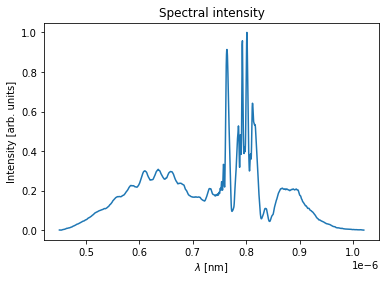

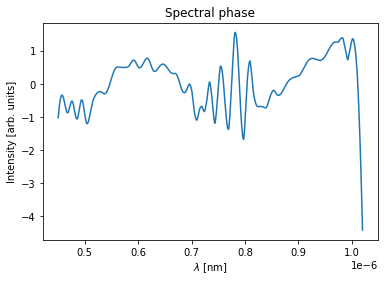

In [14]:
plt.figure()
plt.title('Spectral intensity')
plt.plot(wavelength, intensity)
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel(r'Intensity [arb. units]')

plt.figure()
plt.title('Spectral phase')
plt.plot(wavelength, spectral_phase)
plt.xlabel(r'$\lambda$ [nm]')
plt.ylabel(r'Intensity [arb. units]')

$$E(z,t) \propto \frac{1}{2\pi} \int_{-\infty}^{\infty}\!\! dk \; \lambda^2
                \sqrt{I(2\pi/k)}
                \,e^{i\phi(2\pi/k)}\,e^{i k (z-z0 -ct)}$$

Evaluating at $z-ct = z0$:

In [15]:
lambda0 = np.trapz(wavelength*intensity, wavelength) * \
                        1. / np.trapz(intensity, wavelength)
k0 = 2 * np.pi / lambda0
print('lambda0',lambda0, 'k0', k0)

lambda0 7.262734481312344e-07 k0 8651266.71413746


In [16]:
Ninterp = 1000
lambda_resolution = lambda0 / Ninterp  # spectral resolution
dt = lambda_resolution / c
time_window = lambda0 * lambda0 / c / lambda_resolution
Nt = np.round(time_window/dt).astype(int)



# Define the time array and its corresponding frequency array
time_arr = -0.5*time_window + dt*np.arange(Nt)
omega_arr = 2*np.pi * np.fft.fftfreq( Nt, dt )

In [17]:
spectral_inten_fn = interp1d( omega_axis,
                              intensity*wavelength**2,
                              fill_value=0, bounds_error=False)
spectral_phase_fn = interp1d( omega_axis, spectral_phase,
                              fill_value=0, bounds_error=False)

In [18]:
wavenumber = 2*np.pi / wavelength

spectral_Efield = np.sqrt( spectral_inten_fn(omega_arr) ) * \
                    np.exp( 1j*spectral_phase_fn(omega_arr) )
temporal_Efield = np.fft.fftshift(np.fft.fft(spectral_Efield))

# Ek = wavelength**2 * np.sqrt(intensity)*np.exp(1j*spectral_phase)
Ez = np.fft.fftshift(np.fft.fft(spectral_Efield))
Ez_n = Ez / max(abs(Ez))

(-80.0, 80.0)

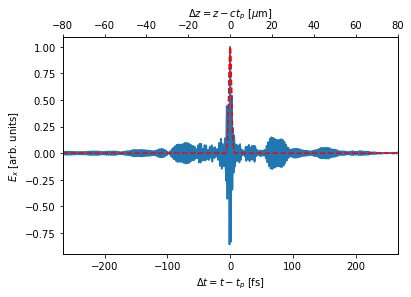

In [19]:
fig,ax = plt.subplots()
Ezr = np.real(Ez)
ax.plot(time_arr*1e15, Ezr / max(Ezr))
# envelope
ax.plot(time_arr*1e15, np.exp(-time_arr**2/(3e-15)**2),'--r')
Ezabs = np.abs(Ez)
# plt.plot(Ezabs / max(Ezabs))

# plt.plot(time_arr, )
# plt.xlim(550,750)
# plt.xlim(-20e-15, 20e-15)
xlim = 80e-6 #micron
ax.set_xlabel(f'$\Delta t=t-t_p$ [fs]')
ax.set_ylabel(r'$E_x$ [arb. units]')
ax.set_xlim(-xlim/c*1e15,xlim/c*1e15)

ax2 = ax.twiny()
ax2.plot(c*time_arr*1e6, Ezr / max(Ezr))
ax2.plot(c*time_arr*1e6, np.exp(-time_arr**2/(3e-15)**2),'--r')
ax2.set_xlabel(f'$\Delta z=z-ct_p$ [$\mu$m]')
ax2.set_xlim(-xlim*1e6,xlim*1e6)

(-15.0, 15.0)

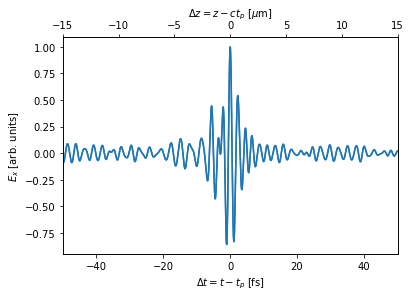

In [20]:
fig,ax = plt.subplots()
Ezr = np.real(Ez)
ax.plot(time_arr*1e15, Ezr / max(Ezr))
Ezabs = np.abs(Ez)
# plt.plot(Ezabs / max(Ezabs))

# plt.plot(time_arr, )
# plt.xlim(550,750)
# plt.xlim(-20e-15, 20e-15)
xlim = 15e-6 #micron
ax.set_xlabel(f'$\Delta t=t-t_p$ [fs]')
ax.set_ylabel(r'$E_x$ [arb. units]')
ax.set_xlim(-xlim/c*1e15,xlim/c*1e15)

ax2 = ax.twiny()
ax2.plot(c*time_arr*1e6, Ezr / max(Ezr))
ax2.set_xlabel(f'$\Delta z=z-ct_p$ [$\mu$m]')
ax2.set_xlim(-xlim*1e6,xlim*1e6)


## Compare computed intensity with measured intensity

In [12]:
temporal_file = '../data/retrieval04_retrieved_pulse.csv' # replace with location of data

In [13]:
data = np.loadtxt(temporal_file,delimiter=',',skiprows=1)
times, intensity_t, intensity_tl = data.T

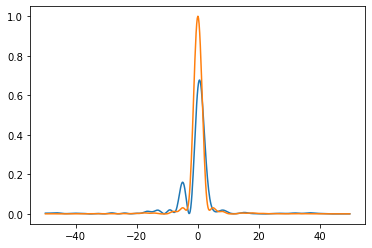

In [14]:
plt.figure()
plt.plot(times,intensity_t)
plt.plot(times,intensity_tl)

(-15.0, 15.0)

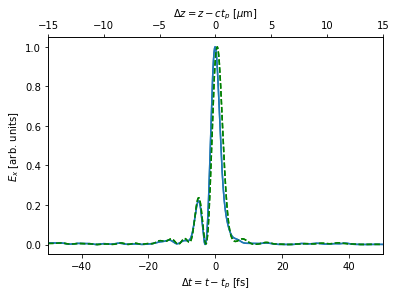

In [15]:
fig,ax = plt.subplots()
intensity = abs(Ez)**2
normal_intensity = intensity / max(intensity)
ax.plot(time_arr*1e15, normal_intensity)
ax.plot(times, intensity_t/max(intensity_t),'--g')

# plt.plot(Ezabs / max(Ezabs))

# plt.plot(time_arr, )
# plt.xlim(550,750)
# plt.xlim(-20e-15, 20e-15)
# xlim = 80e-6 #micron
ax.set_xlabel(f'$\Delta t=t-t_p$ [fs]')
ax.set_ylabel(r'$E_x$ [arb. units]')
ax.set_xlim(-xlim/c*1e15,xlim/c*1e15)

ax2 = ax.twiny()
ax2.plot(c*time_arr*1e6, normal_intensity)
ax2.plot(times*2.998/10, intensity_t/max(intensity_t),'--g')
ax2.set_xlabel(f'$\Delta z=z-ct_p$ [$\mu$m]')
ax2.set_xlim(-xlim*1e6,xlim*1e6)

## energy and $E_m$
---
$$U= \frac{1}{2}\epsilon_0 \iiint \mathbb{E}^2 dV + \frac{1}{2\mu_0}\iiint \mathbb{B}^2 dV$$
For a plane wave packet in vacuum, $$U=\epsilon_0 \iiint \mathbb{E}^2 dV$$
For $\mathbb{E}(x,r,z)=E_m e^{-r^2/w_0^2} f(z)$,
$$U= \iiint \epsilon_0 E_m^2 e^{-2r^2/w_0^2} f(z)^2 2\pi r dr dz $$
$$U=2\pi \epsilon_0 \left(\frac{w_0^2}{4}\right) \int f(z)^2dz$$
$$ = \frac{\pi\epsilon_0 E_m^2 w_0^2}{2} \int f(z)^2dz$$

$$E_m^2 = \frac{ 2U}{\epsilon_0 \pi w_0^2 \int f(z)^2dz}$$

I would like to replace $\int f(z)^2 dz$ with $\int I(\lambda)d\lambda$, but due to the repeated normalizations these aren't equal and it's not clear what factors would make them equal.

$\int I(\lambda) d\lambda$:

In [16]:
data = np.loadtxt(spectral_file,delimiter=',',skiprows=1)
wavelength, intensity, spectral_phase = data.T
wavelength = 1e-9 * wavelength
omega_axis = 2 * np.pi * c / wavelength

In [17]:
z_integration = np.trapz(intensity, wavelength) 
print('int I(lambda)=',z_integration)

int I(lambda)= 9.866449090315e-08


$\int E^2(x)dx$:

In [56]:
z_arr = c * time_arr
# Ez_abs = abs(Ez)
Ez_r = np.real(Ez)
Ezn = Ez_r / max(Ez_r)
intensity_z = Ezn**2
min_ind = 375000
max_ind = 570000
int_z = np.trapz(intensity_z[min_ind:max_ind],z_arr[min_ind:max_ind])
print('int I(x)=',int_z)

int I(x)= 8.118546509209863e-07


In [55]:
print(z_arr[375000]*1e6, z_arr[570000]*1e6)

-90.78418101640437 50.83914136918631


In [93]:
print('using spectral profile')
w0 = 3.5e-6
U = 2.e-3

print(f'for U = {U:.2e} and w0 = {w0:.2e}')
E_m = np.sqrt(2*U / epsilon_0 / np.pi / w0**2 /int_z)
print(f'Em={E_m:.5e} V/m')

using spectral profile
for U = 2.00e-03 and w0 = 3.50e-06
Em=3.80254e+12 V/m


$$a_0 = \frac{eE_m}{mc^2} \frac{\lambda}{2\pi}$$

In [88]:
a0 = e*E_m * lambda0 / m_e /c**2 / 2 / np.pi
print(f'a0={a0:.4f}')
lambda_alt = 8e-7
a0 = e*E_m * lambda_alt / m_e /c**2 / 2 / np.pi
print(f'a0 (800nm) ={a0:.4f}')

a0=0.8601
a0 (800nm) =0.9475


cf. Gaussian pulse:
For $\mathbb{E}(x,r,z)=E_m e^{-r^2/w_0^2} cos^2(kz) e^{-z^2/(c\tau)^2}$,
$$U= \iiint \epsilon_0 E_m^2 e^{-2r^2/w_0^2} cos^2(kz)e^{-2z^2/c^2\tau^2} 2\pi r dr dz $$
$$U=2\pi \epsilon_0 \left(\frac{w_0^2}{4}\right) \sqrt{2\pi\frac{c^2\tau^2}{4}}\left(\frac{1}{2}-e^{-\omega^2\tau^2/2}\right)$$
$$ = \epsilon_0 E_m^2 w_0^2 c\tau \left(\frac{\pi}{2}\right)^{3/2} \left(\frac{1}{2}-e^{-\omega^2\tau^2/2}\right)$$
If $\omega\tau\gg 1$, as we would anticipate, then
$$E_m^2 \approx \frac{ 2^{5/2}U}{\epsilon_0 \pi^{3/2}w_0^2 c\tau}$$

In [94]:
print('assuming gaussian pulse')
w0 = 3.5e-6
U = 2.e-3
FWHM = 3.3e-15
print(f'for U = {U:.2e}, w0 = {w0:.2e}, and FWHM = {FWHM:.2e}')
tau = FWHM / np.sqrt(2 * np.log(2))
print(f'tau = {tau:.5e}s')
ctau = c * tau
Emg = np.sqrt(2**2.5 * U / (epsilon_0 * np.pi**1.5 * w0**2 * ctau) )
print(f'Em = {Emg:.5e} V/m')

lambda_alt = 8e-7
print(f'for wavelength = {lambda_alt:.2e} m')
a0g = e*Emg * lambda_alt / m_e /c**2 / 2 / np.pi
print(f'a0 (gaussian) = {a0g:.4f}')

assuming gaussian pulse
for U = 2.00e-03, w0 = 3.50e-06, and FWHM = 3.30e-15
tau = 2.80276e-15s
Em = 4.72165e+12 V/m
for wavelength = 8.00e-07 m
a0 (gaussian) = 1.1765


a0 (gaussian) =1.1765


In [4]:
a0g = e*Emg * lambda0 / m_e /c**2 / 2 / np.pi
print(f'a0 (gaussian) ={a0g:.4f}')

NameError: name 'lambda0' is not defined


If $\omega\tau <\sim 1$, then
$$E_m^2 \approx \frac{ 2^{5/2}U}{\epsilon_0 \pi^{3/2}w_0^2 c\tau (1 - 2\exp(-\omega^2\tau^2/2))}$$

In [84]:
w0 = 3.5e-6
U = 2e-3
FWHM = 3.3e-15
# tau = FWHM / np.sqrt(2 * np.log(2))
tau = FWHM
ctau = c * tau
lambda_alt = 8e-7
kL = 2*np.pi / lambda_alt
exp_arg = (kL*ctau/2)**2
print('exp arg', exp_arg)
Emg = np.sqrt(2**2.5 * U / (epsilon_0 * np.pi**1.5 * w0**2 * ctau * (1-2*np.exp(-(kL*ctau/2)**2))) )
print(f'Em={Emg:.5e} V/m')

a0g = e*Emg * lambda_alt / m_e /c**2 / 2 / np.pi
print(f'a0 (gaussian) ={a0g:.4f}')

exp arg 15.093468649337238
Em=4.35141e+12 V/m
a0 (gaussian) =1.0842


## If it is desired to create an openPMD-formatted file:
openpmd_api must be installed

In [23]:
import openpmd_api as io

In [24]:
# write to openPMD format

series = io.Series("../myOutput/spectral_data.h5", io.Access.create)
i = series.iterations[1]
series.author = "Ryan Sandberg <rsandberg@lbl.gov>"


E = i.meshes["E"]
# [io.Mesh_Record_Component.SCALAR]
E.geometry = io.Geometry.cartesian
# Ez = E[io.Mesh_Record_Component.SCALAR]
E.grid_spacing = [dt]
print('dt=',dt)
E.grid_global_offset = [time_arr[0]]
E.axis_labels = ['z']
E.data_order = "C"
E.unit_dimension = {io.Unit_Dimension.I: 1.0,
                    io.Unit_Dimension.J: 2.0}
E.grid_unit_SI = 1.0

Ex = E["x"]
Ex.unit_SI = 1.
Ex.position = [0]

Ex.reset_dataset(io.Dataset(Ez.dtype, Ez.shape))
Ex.store_chunk(Ez_n)
series.flush()

# E[()] = E

# series.flush()
del series

dt= 2.422587455923372e-18


In [25]:
series = io.Series("../myOutput/spectral_data.h5", io.Access.read_only)
for i in series.iterations:
    print("\t {0}".format(i))
print("")
i = series.iterations[1]
E = i.meshes["E"]
E_x = E["x"]
print("Field E.x has shape {0} and datatype {1}".format(E_x.shape, E_x.dtype))
Exdata = E_x.load_chunk()
series.flush()
extent = E_x.shape

print(
    "E_x has shape: ",
    extent)

t0_r = E.grid_global_offset[0]
print(Exdata[:5])
dt_r = E.grid_spacing
print('dt', dt_r)
tf_r = t0_r + dt_r[0] * (extent[0]-1)

print('t0=',t0_r, 'tf=', tf_r)
del series

	 1

Field E.x has shape [1000000] and datatype complex128
E_x has shape:  [1000000]
[5.40132731e-05-0.00013567j 5.34776102e-05-0.0001358j
 5.29425927e-05-0.00013593j 5.24082081e-05-0.00013605j
 5.18744434e-05-0.00013617j]
dt [2.422587455923372e-18]
t0= -1.2112937279616862e-12 tf= 1.2112913053742297e-12


Text(0, 0.5, '$E_x$ [arb. units]')

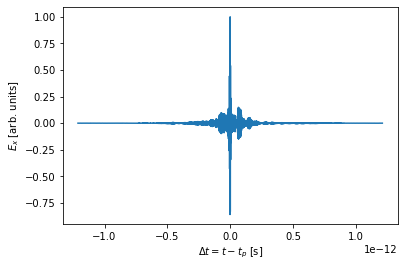

In [26]:
plt.figure()
Ezr = np.real(Exdata)
plt.plot(time_arr, Ezr )
# plt.plot(Ezabs / max(Ezabs))

# plt.plot(time_arr, )
# plt.xlim(550,750)
# plt.xlim(-20e-15, 20e-15)
plt.xlabel(f'$\Delta t=t-t_p$ [s]')
plt.ylabel(r'$E_x$ [arb. units]')

Text(0, 0.5, '$E_x$ [arb. units]')

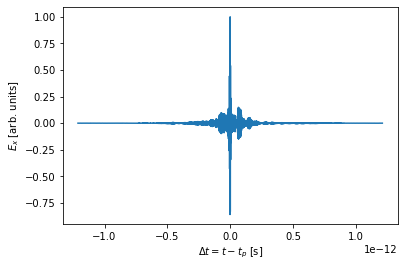

In [27]:
plt.figure()
Ezr = np.real(Ez)
plt.plot(time_arr, Ezr / max(Ezr))
Ezabs = np.abs(Ez)
# plt.plot(Ezabs / max(Ezabs))

# plt.plot(time_arr, )
# plt.xlim(550,750)
# plt.xlim(-20e-15, 20e-15)
plt.xlabel(f'$\Delta t=t-t_p$ [s]')
plt.ylabel(r'$E_x$ [arb. units]')